In [90]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv("movies.csv", encoding='latin-1')
data.head()

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year
0,8000000.00,Columbia Pictures Corporation,USA,Rob Reiner,Adventure,52287414.00,Stand by Me,R,1986-08-22,89,8.10,Wil Wheaton,299174,Stephen King,1986
1,6000000.00,Paramount Pictures,USA,John Hughes,Comedy,70136369.00,Ferris Bueller's Day Off,PG-13,1986-06-11,103,7.80,Matthew Broderick,264740,John Hughes,1986
2,15000000.00,Paramount Pictures,USA,Tony Scott,Action,179800601.00,Top Gun,PG,1986-05-16,110,6.90,Tom Cruise,236909,Jim Cash,1986
3,18500000.00,Twentieth Century Fox Film Corporation,USA,James Cameron,Action,85160248.00,Aliens,R,1986-07-18,137,8.40,Sigourney Weaver,540152,James Cameron,1986
4,9000000.00,Walt Disney Pictures,USA,Randal Kleiser,Adventure,18564613.00,Flight of the Navigator,PG,1986-08-01,90,6.90,Joey Cramer,36636,Mark H. Baker,1986


In [2]:
pd.options.display.float_format = '{:.2f}'.format
#pd.reset_option('^display.', silent=True)

In [72]:
#Data understanding
for column in data.columns:
    print(data[column].value_counts())

0.00            2182
20000000.00      207
30000000.00      191
25000000.00      177
15000000.00      170
10000000.00      155
40000000.00      150
35000000.00      149
50000000.00      115
5000000.00       113
60000000.00      107
12000000.00      102
6000000.00        90
8000000.00        88
18000000.00       88
13000000.00       76
7000000.00        73
3000000.00        73
45000000.00       72
17000000.00       65
80000000.00       65
70000000.00       65
11000000.00       62
16000000.00       60
14000000.00       58
22000000.00       57
4000000.00        55
75000000.00       54
55000000.00       54
100000000.00      49
                ... 
260000000.00       1
8900000.00         1
12800000.00        1
10920000.00        1
63600000.00        1
9200000.00         1
65000.00           1
126000000.00       1
29750000.00        1
17700000.00        1
176000000.00       1
169000.00          1
26350000.00        1
5600000.00         1
230000000.00       1
144000000.00       1
11800000.00  

# Prepearing the dataset for processing

In [91]:
#Get the names of movies with no budget and format the string for a URL
noBudgetMovies = data[data["budget"]==0][["year","name"]]
noBudgetMovies["name"] = noBudgetMovies["name"].str.replace(" ","_")
noBudgetMovies.head()

,year,name
25,1986,Short_Circuit
26,1986,The_Name_of_the_Rose
27,1986,Iron_Eagle
32,1986,Betty_Blue
35,1986,The_Karate_Kid_Part_II


### Requesting the missing budget values from Wikipedia API

In [92]:
from bs4 import BeautifulSoup
import requests

def getPage(movieName):
    S = requests.Session()
    URL = "https://en.wikipedia.org/w/api.php"
    PARAMS = {
        "action": "parse",
        "page": movieName,
        "format": "json"
    }
    R = S.get(url=URL, params=PARAMS)
    DATA = R.json()
    return DATA

#Getting the budget value
def getBudget(DATA):
    try:
        soup = BeautifulSoup("<html>"+str(DATA["parse"]["text"]["*"])+"</html>",features="html.parser")
    except:
        return "parseError"
    table = soup.find("table",class_="infobox vevent")

    try:
        thList = table.find_all("th")
        tdList = table.find_all("td")
    except:
        return "redirect"

    budgetIndex = -1
    i=0
    for row in thList:
        if "Budget" in str(row):
            budgetIndex = i
            break
        i += 1

    if budgetIndex == -1:
        return "noBudget"
    
    budget = tdList[budgetIndex].contents
    
    try:
        if len(budget)==1 or len(budget)==2 and "reference" in budget[1]["class"]:
            return tdList[budgetIndex].contents[0]
    except:
        pass
    return budget

In [7]:
#Sends GET requests to wikipedia API to get the missing budget values
#Takes a long time ~35min
dict = {}

for movieName in noBudgetMovies["name"]:
    pageData = getPage(movieName)
    budget = getBudget(pageData)
    
    if budget=="redirect":
        name = movieName+"_(film)"
        pageData = getPage(name)
        budget = getBudget(pageData)
        if budget=="redirect":
            year = noBudgetMovies[noBudgetMovies["name"]==movieName]["year"].values[0]
            name = movieName+"_("+str(year)+"_film)"
            pageData = getPage(name)
            budget = getBudget(pageData)
            if budget=="redirect":
                dict[movieName] = "redirect. last tried name: "+name
                continue
    if budget=="noBudget":
        dict[movieName] = "noBudget"
        continue
    if budget=="parseError":
        dict[movieName] = "parseError"
        continue
    dict[movieName] = budget

KeyboardInterrupt: 

In [ ]:
#DO NOT RUN AGAIN IF YOU ALREADY HAVE RESULTS IN A FILE OR MAKE A BACKUP FIRST, BECAUSE API REQUESTS TAKE A LONG TIME TO GET!!!
#Writing dict to file for further processing. 
with open("wikiResults.txt","w",encoding="utf-8") as file:
    for key, value in dict.items():
        file.write(key+"==="+str(value).replace("\n"," ")+"\n")

### Take the budget values and parse them into floats

In [93]:
#Read the results from the file onto a new dictionary
dictFile = {}
with open("wikiResults.txt","r",encoding="utf-8") as file:
    lines = file.readlines()
for line in lines:
    if line=="":
        continue
    split = line.split("===")
    dictFile[split[0]] = split[1].replace("\n","")

In [94]:
def findNumericDigits(string):
    index = 0
    i =0
    for char in string:
        if char.isnumeric():
            index = i
            break
        i += 1
    return index

def parseBudgetValue(budget):
    currencies = {
        "£": 1.33,
        "€": 1.11,
        "AU$": 0.688
    }
    
    try:
        if "sup" in budget:
            return budget
        if "million" in budget or "Million" in budget:
            row = budget.split(" ")
            firstNr = findNumericDigits(row[0])
            value = budget[:firstNr]+str(float(row[0][firstNr:])*1000000)
        elif ","in budget:
            value = budget.replace(",","")
        else:
            value = budget

        if value[0] == "$":
            return float(value[1:])
        elif value[:3] == "US$":
            return float(value[3:])
        elif value[0] == "£":
            return float(value[1:])*currencies["£"]
        elif value[0] == "€":
            return float(value[1:])*currencies["€"]
        elif value[:3] == "AU$":
            return float(value[3:])*currencies["AU$"]
        elif value[:2] == "A$":
            return float(value[2:])*currencies["AU$"]
        else:
            return budget
    except:
        return budget

In [95]:
#Parse the value into a float
for key, value in dictFile.items():
    dictFile[key] = parseBudgetValue(value)

In [12]:
#Manual fixing of remaining errors
errors = ["noBudget","parseError","redirect"]
moviesWithErrors = []
for key, value in dictFile.items():
    if type(value)!= float and value not in errors:
        moviesWithErrors.append(key)
        print(key,value)
        budget = input("Enter new budget value: ")
        if budget == "":
            continue
        dictFile[key] = budget

Summer redirect. last tried name: Summer_(1986_film)
Enter new budget value: 
Link Unknown
Enter new budget value: 
Kangaroo redirect. last tried name: Kangaroo_(1986_film)
Enter new budget value: 
Wings_of_Desire ['5 million ', <a href="/wiki/Deutsche_Mark" title="Deutsche Mark">DM</a>, <sup class="reference" id="cite_ref-FOOTNOTELüdiLüdi200060_3-0"><a href="#cite_note-FOOTNOTELüdiLüdi200060-3">[3]</a></sup>]
Enter new budget value: 5 million Deutsche_Mark
Who's_That_Girl $17–20 million ($37.49 million in 2018)
Enter new budget value: $18.5 million
Wanted:_Dead_or_Alive $4,500,000 (US)
Enter new budget value: $4,500,000
Wisdom ['$6.5 million', <sup class="reference" id="cite_ref-2"><a href="#cite_note-2">[2]</a></sup>, <sup class="reference" id="cite_ref-globe_3-0"><a href="#cite_note-globe-3">[3]</a></sup>]
Enter new budget value: $6.5 million
The_Allnighter approx $1 million
Enter new budget value: $1 million
The_Bedroom_Window ['$8.3 million', <sup class="reference" id="cite_ref-cu

In [20]:
#DO NOT RUN AGAIN. THIS WRITES THE MANUALLY INSERTED VALUES INTO A FILE
#Backup the dictFile with the new manually inserted values
with open("manuallyInserted.txt","w",encoding="utf-8") as file:
    for key, value in dictFile.items():
        file.write(key+"==="+str(value).replace("\n"," ")+"\n")

In [96]:
#Run after fresh start to get the manually fixed budget values
with open("manuallyInserted.txt","r",encoding="utf-8") as file:
    lines = file.readlines()
for line in lines:
    if line=="":
        continue
    split = line.split("===")
    dictFile[split[0]] = split[1].replace("\n","")

### Add the newfound values into the set

In [97]:
for key, value in dictFile.items():
    if type(value)==float:
        data[data["name"] == key.replace("_"," ")] = data[data["name"] == key.replace("_"," ")].replace(to_replace=0.0,value=value)

### Encoding labels

In [168]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

##strings to numbers
le = LabelEncoder()
le.fit(data['company'])
data['company'] = labelEncoder.transform(data['company'])

le1 = LabelEncoder()
le1.fit(data['country'])
data['country'] = le1.transform(data['country'])

le2 = LabelEncoder()
le2.fit(data['director'])
data['director'] = le2.transform(data['director'])

le3 = LabelEncoder()
le3.fit(data['genre'])
data['genre'] = le3.transform(data['genre'])

le4 = LabelEncoder()
le4.fit(data['name'])
data['name'] = le4.transform(data['name'])

le5 = LabelEncoder()
le5.fit(data['rating'])
data['rating'] = le5.transform(data['rating'])

le6 = LabelEncoder()
le6.fit(data['star'])
data['star'] = le6.transform(data['star'])

le7 = LabelEncoder()
le7.fit(data['writer'])
data['writer'] = le7.transform(data['writer'])

le8 = LabelEncoder()
le8.fit(data['released'])
data['released'] = le8.transform(data['released'])


data.head(20)

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year
0,8000000.00,665,54,2192,1,52287414.00,4661,8,39,89,8.10,2454,299174,3716,1986
1,6000000.00,1680,54,1296,4,70136369.00,1821,7,27,103,7.80,1605,264740,1970,1986
2,15000000.00,1680,54,2645,0,179800601.00,6203,6,23,110,6.90,2345,236909,1852,1986
3,18500000.00,2062,54,1066,0,85160248.00,295,8,33,137,8.40,2192,540152,1629,1986
4,9000000.00,2122,54,2123,1,18564613.00,1872,6,36,90,6.90,1139,36636,2549,1986
5,6000000.00,1158,53,1948,6,138530565.00,3903,8,75,120,8.10,369,317585,2988,1986
6,25000000.00,1160,53,1207,1,12729917.00,2883,6,30,101,7.40,528,102879,977,1986
7,6000000.00,768,54,588,6,8551228.00,771,8,51,120,7.80,924,146768,897,1986
8,9000000.00,1680,54,1004,4,40471663.00,3964,7,9,96,6.80,1730,60565,1970,1986
9,15000000.00,1854,54,557,6,40456565.00,5306,8,38,96,7.50,1039,129698,1333,1986


### Drop all movies with no budget

In [173]:
data = data[data["budget"]!=0]

# Working with the data

In [82]:
labels = data["gross"]
movie_data = data.drop(["gross"],1)

X_train, X_test, y_train, y_test = train_test_split(movie_data, labels, test_size = 0.3, random_state = 0)

In [180]:
rf = RandomForestClassifier(criterion="gini",n_estimators=80, max_depth=160).fit(X_train, y_train)
predictions = rf.predict(X_test)
pList = predictions.tolist()

In [181]:
accuracyResults = pd.DataFrame(columns=["name","realGross","predictedGross","difference"])
for i in range(len(pList)):
    row = X_test.iloc[i]
    label = y_test.iloc[i]
    accuracyResults = accuracyResults.append({"name":row["name"],"realGross":label,"predictedGross":pList[i],"difference":abs(label-pList[i])},ignore_index=True)

with open("modelsUsed.txt","a",encoding="utf-8") as f:
    f.write("model==="+str(rf)+"\tmean==="+str(accuracyResults["difference"].mean())+"\n")
accuracyResults["difference"].describe()

count        1392.00
mean     31746062.17
std      45039344.28
min            14.00
25%       5461651.00
50%      17427617.50
75%      39868725.50
max     604882902.00
Name: difference, dtype: float64

In [171]:
#Make labels human readable again
data['company'] = labelEncoder.inverse_transform(data['company'])
data['country'] = le1.inverse_transform(data['country'])
data['director'] = le2.inverse_transform(data['director'])
data['genre'] = le3.inverse_transform(data['genre'])
data['name'] = le4.inverse_transform(data['name'])
data['rating'] = le5.inverse_transform(data['rating'])
data['star'] = le6.inverse_transform(data['star'])
data['writer'] = le7.inverse_transform(data['writer'])
data['released'] = le8.inverse_transform(data['released'])

data.head()

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year
0,8000000.00,Columbia Pictures Corporation,USA,Rob Reiner,Adventure,52287414.00,Stand by Me,R,1986-08-22,89,8.10,Wil Wheaton,299174,Stephen King,1986
1,6000000.00,Paramount Pictures,USA,John Hughes,Comedy,70136369.00,Ferris Bueller's Day Off,PG-13,1986-06-11,103,7.80,Matthew Broderick,264740,John Hughes,1986
2,15000000.00,Paramount Pictures,USA,Tony Scott,Action,179800601.00,Top Gun,PG,1986-05-16,110,6.90,Tom Cruise,236909,Jim Cash,1986
3,18500000.00,Twentieth Century Fox Film Corporation,USA,James Cameron,Action,85160248.00,Aliens,R,1986-07-18,137,8.40,Sigourney Weaver,540152,James Cameron,1986
4,9000000.00,Walt Disney Pictures,USA,Randal Kleiser,Adventure,18564613.00,Flight of the Navigator,PG,1986-08-01,90,6.90,Joey Cramer,36636,Mark H. Baker,1986


In [148]:
accuracyResults.apply (pd.to_numeric, errors='coerce')
accuracyResults = accuracyResults.dropna()
accuracyResults

,name,realGross,predictedGross,difference
0,118.00,7458269.00,81159365.00,73701096.00
1,2398.00,31155435.00,11438337.00,19717098.00
2,3597.00,31487293.00,50294317.00,18807024.00
3,3944.00,23000.00,389804.00,366804.00
4,4608.00,52008288.00,10269307.00,41738981.00
5,2210.00,261988482.00,58220776.00,203767706.00
6,4304.00,83301580.00,5209580.00,78092000.00
7,4173.00,63095271.00,36300000.00,26795271.00
8,6295.00,57141459.00,35193167.00,21948292.00
9,6210.00,58877969.00,132556852.00,73678883.00


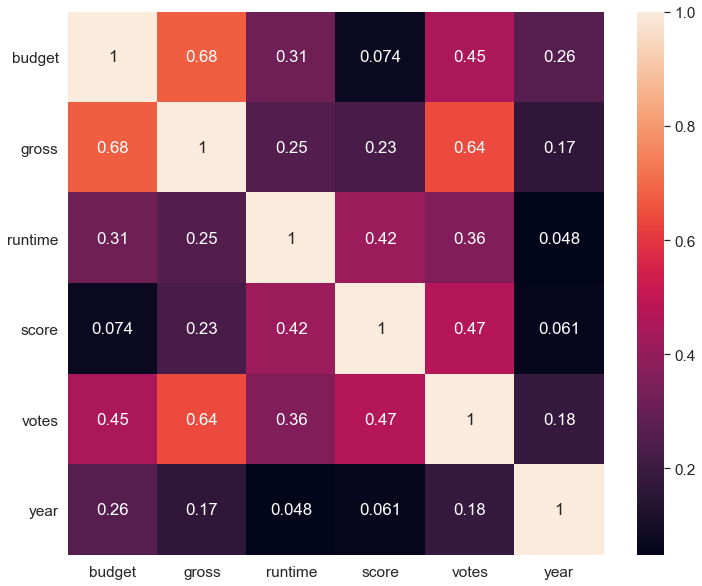

In [176]:
#Making a heatmap of all correlations
import seaborn as sns
correlations = data.corr()
plt.figure(figsize=(12, 10))
sns.set(font_scale=1.4)
sns.heatmap(correlations,annot=True)
plt.yticks(rotation=0)
plt.savefig("correlations.png")

In [149]:
accuracyResults["realGross"] = accuracyResults["realGross"]/1000000
accuracyResults["predictedGross"] = accuracyResults["predictedGross"]/1000000
accuracyResults["difference"] = accuracyResults["difference"]/1000000
accuracyResults

,name,realGross,predictedGross,difference
0,118.00,7.46,81.16,73.70
1,2398.00,31.16,11.44,19.72
2,3597.00,31.49,50.29,18.81
3,3944.00,0.02,0.39,0.37
4,4608.00,52.01,10.27,41.74
5,2210.00,261.99,58.22,203.77
6,4304.00,83.30,5.21,78.09
7,4173.00,63.10,36.30,26.80
8,6295.00,57.14,35.19,21.95
9,6210.00,58.88,132.56,73.68


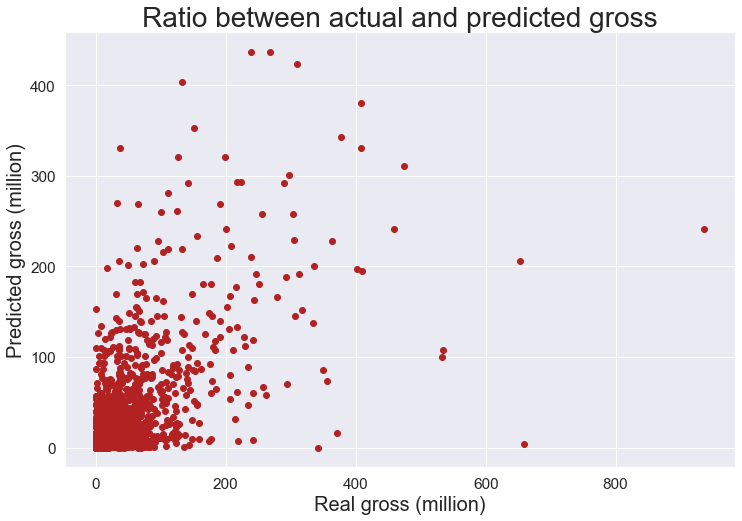

In [179]:
plt.figure(figsize=(12, 8))
plt.scatter(accuracyResults["realGross"],accuracyResults["predictedGross"],color="firebrick")
plt.xlabel("Real gross (million)",fontsize=20)
plt.ylabel("Predicted gross (million)",fontsize=20)
plt.title("Ratio between actual and predicted gross",fontsize=28)
plt.savefig("ratio.png")

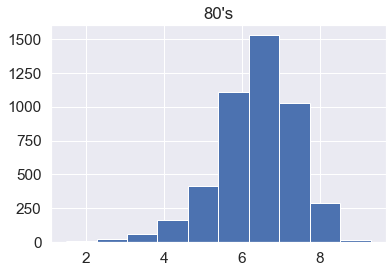

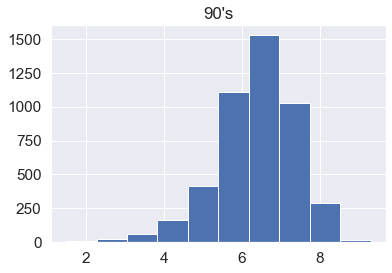

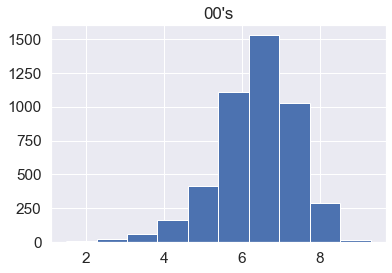

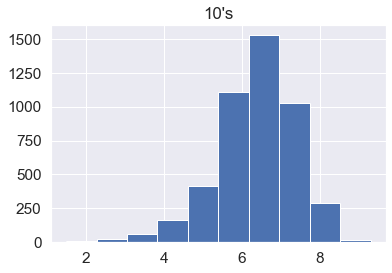

<BarContainer object of 4 artists>

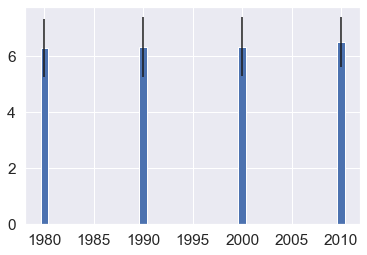

In [254]:
#Find different plots for different decades
means = {}
stdevs = {}
feature = "score"
for i in range(1980,2016,10):
    decades = data[(data["year"]>i) & (data["year"]<i+10)]
    means[i] = decades[feature].mean()
    stdev = decades[feature].std()
    stdevs[i] = stdev
    plt.title(str(i)[-2:]+"'s")
    plt.hist(data[feature])
    plt.show()

plt.bar(list(means.keys()),list(means.values()),yerr=list(stdevs.values()))

In [115]:
from scipy import stats

#the biggest correlations between gross and a feature
#budget
pearson_coef, p_value = stats.pearsonr(data["budget"], data["gross"])
print("Pearson Correlation Coefficient: ", pearson_coef)

Pearson Correlation Coefficient:  0.7121955325421071


In [116]:
#votes
pearson_coef, p_value = stats.pearsonr(data["votes"], data["gross"])
print("Pearson Correlation Coefficient: ", pearson_coef)

Pearson Correlation Coefficient:  0.6624571618429045


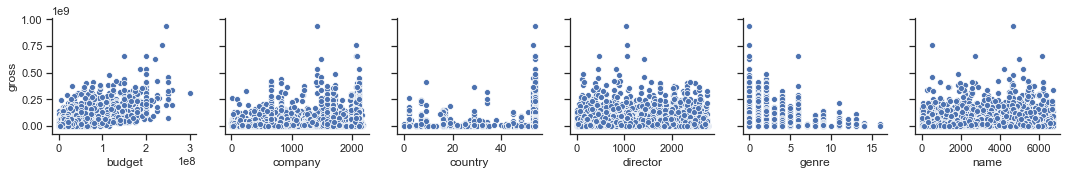

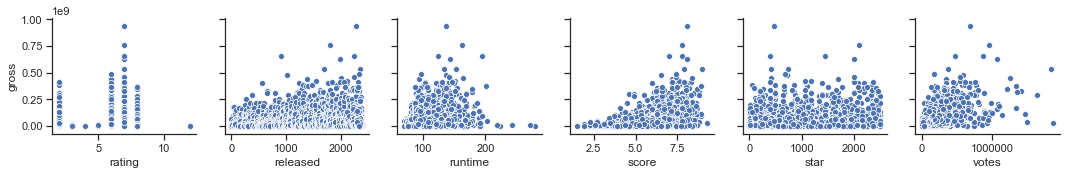

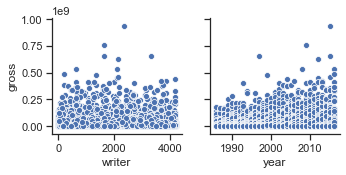

In [42]:
#correlation between gross and other features
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(data = data, x_vars = ["budget","company","country","director","genre","name"], y_vars = ["gross"])
g = sns.pairplot(data = data, x_vars = ["rating","released","runtime","score","star","votes"], y_vars = ["gross"])
g = sns.pairplot(data = data, x_vars = ["writer","year"], y_vars = ["gross"])

In [117]:
sort = data.sort_values(by = ["gross"], ascending=[False])

In [118]:
#finding the 100 movies with biggest gross
biggest_values = sort.head(100)
biggest_values.head()

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year
6380,245000000.00,Lucasfilm,USA,J.J. Abrams,Action,936662225.00,Star Wars: The Force Awakens,PG-13,2015-12-18,136,8.10,Daisy Ridley,687192,Lawrence Kasdan,2015
5061,237000000.00,Twentieth Century Fox Film Corporation,UK,James Cameron,Action,760507625.00,Avatar,PG-13,2009-12-18,162,7.80,Sam Worthington,954412,James Cameron,2009
2420,200000000.00,Twentieth Century Fox Film Corporation,USA,James Cameron,Drama,658672302.00,Titanic,PG-13,1997-12-19,194,7.80,Leonardo DiCaprio,862554,James Cameron,1997
6391,150000000.00,Universal Pictures,USA,Colin Trevorrow,Action,652270625.00,Jurassic World,PG-13,2015-06-12,124,7.00,Chris Pratt,469200,Rick Jaffa,2015
5723,220000000.00,Marvel Studios,USA,Joss Whedon,Action,623357910.00,The Avengers,PG-13,2012-05-04,143,8.10,Robert Downey Jr.,1064633,Joss Whedon,2012


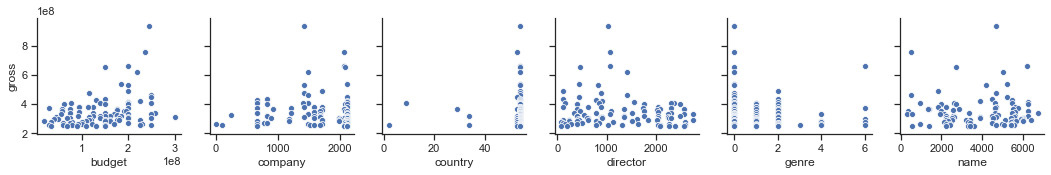

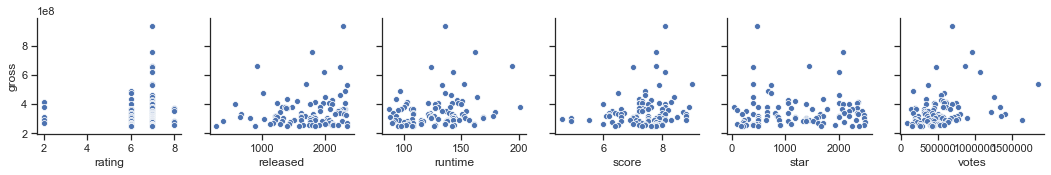

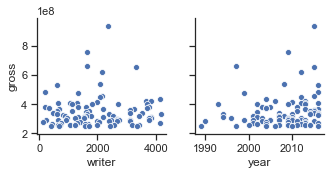

In [45]:
g = sns.pairplot(data = biggest_values, x_vars = ["budget","company","country","director","genre","name"], y_vars = ["gross"])
g = sns.pairplot(data = biggest_values, x_vars = ["rating","released","runtime","score","star","votes"], y_vars = ["gross"])
g = sns.pairplot(data = biggest_values, x_vars = ["writer","year"], y_vars = ["gross"])

In [46]:
#finding data, where gross is at least twice the budget

best_data = pd.DataFrame(data, columns = ["budget","company","country","director","genre","gross","name","rating","released",
                                          "runtime","score","star","votes","writer","year"])

# for i in range(len(best_data)):
#     if best_data.iloc[i,:].budget == 0.0 or best_data.iloc[i,:].budget == 0:
#         best_data.drop(best_data.index[i])
        
for i in range(len(best_data)):
    if best_data.iloc[i,:].gross/best_data.iloc[i,:].budget < 2:
        best_data.drop(best_data.index[i])
        
best_data.head()

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year
0,8000000.00,665,54,2192,1,52287414.00,4661,8,39,89,8.10,2454,299174,3716,1986
1,6000000.00,1680,54,1296,4,70136369.00,1821,7,27,103,7.80,1605,264740,1970,1986
2,15000000.00,1680,54,2645,0,179800601.00,6203,6,23,110,6.90,2345,236909,1852,1986
3,18500000.00,2062,54,1066,0,85160248.00,295,8,33,137,8.40,2192,540152,1629,1986
4,9000000.00,2122,54,2123,1,18564613.00,1872,6,36,90,6.90,1139,36636,2549,1986


In [47]:
data = pd.read_csv("movies.csv", encoding='latin-1')

best_data = pd.DataFrame(data, columns = ["budget","company","country","director","genre","gross","name","rating","released",
                                          "runtime","score","star","votes","writer","year"])

for i in range(len(best_data)):
    if best_data.iloc[i,:].gross/best_data.iloc[i,:].budget < 2:
        best_data.drop(best_data.index[i])

C:\Users\Silver\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys


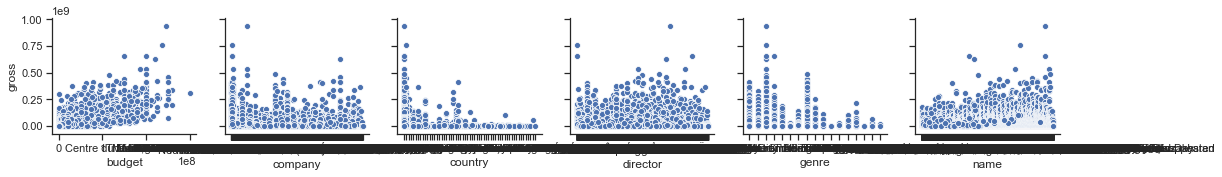

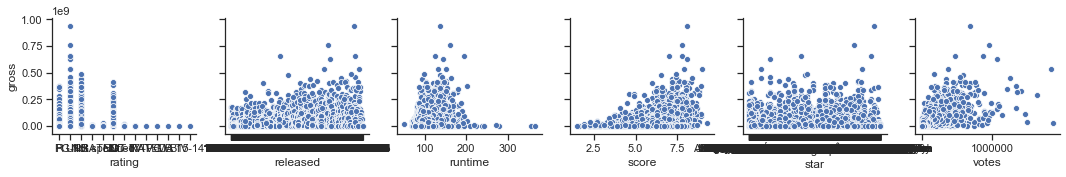

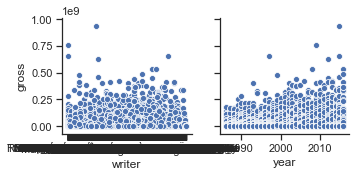

In [48]:
g = sns.pairplot(data = best_data, x_vars = ["budget","company","country","director","genre","name"], y_vars = ["gross"])
g = sns.pairplot(data = best_data, x_vars = ["rating","released","runtime","score","star","votes"], y_vars = ["gross"])
g = sns.pairplot(data = best_data, x_vars = ["writer","year"], y_vars = ["gross"])